In [1]:
from psrpop import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from oompy import Units as u


def SampleDistance(A, B):
    means_A = A.mean(axis=0)
    vars_A = A.var(axis=0) / 2

    A = (A - means_A) / vars_A
    B = (B - means_A) / vars_A

    nA = len(A)
    nB = len(B)

    diffAB = cdist(A, B).sum()
    diffAA = cdist(A, A).sum()
    diffBB = cdist(B, B).sum()

    return (
        (nA + nB)
        / (nA * nB)
        * (2 * diffAB / (nA * nB) - diffAA / nA**2 - diffBB / nB**2)
    )


def IsNormalPulsar(Ps, Pdots):
    # criterion ms-pulsars

    P1_lower, Pdot1_lower = 0.01, 1e-10  # (P, Pdot)
    P2_lower, Pdot2_lower = 1.0, 1e-19  # (P, Pdot)

    logP1_lower, logPdot1_lower = np.log10(P1_lower), np.log10(Pdot1_lower)
    logP2_lower, logPdot2_lower = np.log10(P2_lower), np.log10(Pdot2_lower)

    slope_lower = (logPdot2_lower - logPdot1_lower) / (logP2_lower - logP1_lower)
    intercept_lower = logPdot1_lower - slope_lower * logP1_lower

    P_line_lower = np.logspace(np.log10(P1_lower), np.log10(P2_lower), 100)
    Pdot_line_lower = 10 ** (slope_lower * np.log10(P_line_lower) + intercept_lower)

    # criterion magnetars

    P1_upper, Pdot1_upper = 0.1, 1e-10
    P2_upper, Pdot2_upper = 10.0, 1e-14

    logP1_upper, logPdot1_upper = np.log10(P1_upper), np.log10(Pdot1_upper)
    logP2_upper, logPdot2_upper = np.log10(P2_upper), np.log10(Pdot2_upper)

    slope_upper = (logPdot2_upper - logPdot1_upper) / (logP2_upper - logP1_upper)
    intercept_upper = logPdot1_upper - slope_upper * logP1_upper

    return (Pdots < 10 ** (slope_upper * np.log10(Ps) + intercept_upper)) & (
        Pdots > 10 ** (slope_lower * np.log10(Ps) + intercept_lower)
    )

In [50]:
PARAMETERS = {
    "init_model": {
        "position": {  # Table 7, Model C in paper
            "B": 1.90,
            "C": 5.0,
            "E": 0.18,
        },
        "Bsurf": {
            "mean_log10": 12.65,
            "std_log10": 0.55,
        },
        "P": {
            "mean": 0.3,
            "std": 0.15,
            "threshold": 0.85e-3,
        },
    },
    "detectability": {
        "h_em": 3e5 * u.m,
    },
}

pulsars = Simulate_Evolution(
    PARAMETERS,
    birth_rate=2 / 100,
    total_time=1e8,
    nbraking=2.5,
    beta=0.05,
)

In [51]:
catalog = Read_Catalogue()

In [52]:
detectable_pulsars = (
    pulsars.select(Detectable_Geometric, PARAMETERS)
    .select(Detectable_Radioflux, PARAMETERS)
    .select(lambda psr, _: IsNormalPulsar(psr.Ps, psr.Pdots), PARAMETERS)
)
detectable_pulsars.number

1953

number of observed psrs 2139
number of synthetic psrs 1953


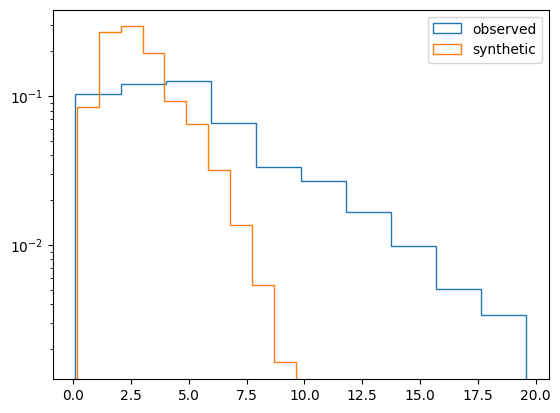

In [61]:
mask = (catalog["P0"] != "*") & (catalog["P1"] != "*") & (catalog["DIST"] != "*")
dist = catalog["DIST"][mask].astype(float)
p0 = catalog["P0"][mask].astype(float)

observed_dist = dist[(dist < 20) & (p0 > 0.1)]
print("number of observed psrs", len(observed_dist))

synthetic_dist = detectable_pulsars.distances
print("number of synthetic psrs", len(synthetic_dist))

plt.hist(observed_dist, histtype="step", density=True, label="observed")
plt.hist(synthetic_dist, histtype="step", density=True, label="synthetic")
plt.legend()
plt.yscale("log")

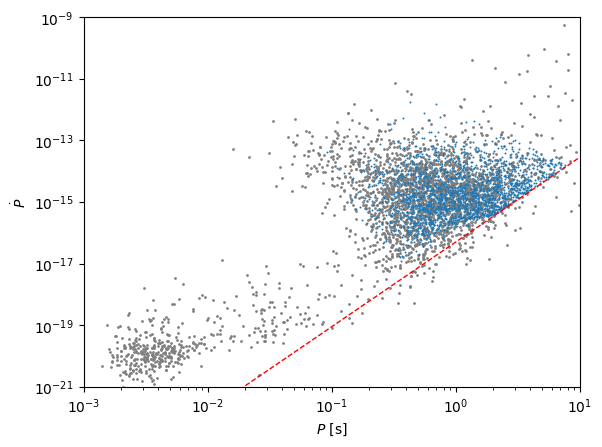

In [6]:
ax = Plot_PPdot(detectable_pulsars, color=None, s=2, lw=0)

mask = (catalog["P0"] != "*") & (catalog["P1"] != "*")

ax.scatter(
    catalog["P0"][mask].astype(float),
    catalog["P1"][mask].astype(float),
    s=1,
    color="gray",
    zorder=-1,
)

In [ ]:
# pack the data into 2D arrays

mask = (catalog["P0"] != "*") & (catalog["P1"] != "*")
real_pulsars_P = np.array(catalog["P0"][mask], dtype=float)
real_pulsars_Pdot = np.array(catalog["P1"][mask], dtype=float)
# real_pulsars_Dist = np.array(catalog["DIST_DM"], dtype=float)

# mask out the nan and negative values
mask = (
    # & ~np.isnan(real_pulsars_Dist)
    (real_pulsars_P > 0)
    & (real_pulsars_Pdot > 0)
    # & (real_pulsars_Dist > 0)
    & IsNormalPulsar(real_pulsars_P, real_pulsars_Pdot)
)

real_pulsars = np.array(
    [
        np.log(real_pulsars_P[mask]),
        np.log(real_pulsars_Pdot[mask]),
        # real_pulsars_Dist[mask],
    ]
).T
synthetic_pulsars = np.array(
    [
        np.log(detectable_pulsars.Ps),
        np.log(detectable_pulsars.Pdots),
        # detectable_pulsars.distances,
    ]
).T

In [ ]:
SampleDistance(real_pulsars, synthetic_pulsars)

In [ ]:
np.linspace(2.5, 3.5, 11)

In [ ]:
n_values = np.linspace(2.5, 3.5, 11)
sample_distance_n = []

for n in n_values:
    print("pulsars with n=", n)

    pulsars = Simulate_Evolution(
        birth_rate=0.2 / 100,
        total_time=1e8,
        nbraking=n,
        beta=0.05,
    )

    detected_pulsars = pulsars.select(Detectable_Geometric).select(Detectable_Radioflux)

    real_pulsars = np.array(
        [
            np.log(real_pulsars_P[mask]),
            np.log(real_pulsars_Pdot[mask]),
            # real_pulsars_Dist[mask],
        ]
    ).T
    synthetic_pulsars = np.array(
        [
            np.log(detected_pulsars.Ps),
            np.log(detected_pulsars.Pdots),
            # detectable_pulsars.distances,
        ]
    ).T

    d = SampleDistance(real_pulsars, synthetic_pulsars)
    print(d)
    sample_distance_n.append(d)

In [ ]:
sample_distance_n

In [ ]:
plt.plot(n_values, sample_distance_n)

In [ ]:
np.linspace(0.01, 0.1, 10)

In [ ]:
# same thing as above but for beta values instead of n
beta_values = np.linspace(0.01, 0.1, 10)
sample_distance_b = []

for beta in beta_values:
    print("pulsars with beta=", beta)

    pulsars = Simulate_Evolution(
        birth_rate=0.2 / 100,
        total_time=1e8,
        nbraking=3,
        beta=beta,
    )

    detected_pulsars = pulsars.select(Detectable_Geometric).select(Detectable_Radioflux)

    real_pulsars = np.array(
        [
            np.log(real_pulsars_P[mask]),
            np.log(real_pulsars_Pdot[mask]),
            # real_pulsars_Dist[mask],
        ]
    ).T
    synthetic_pulsars = np.array(
        [
            np.log(detected_pulsars.Ps),
            np.log(detected_pulsars.Pdots),
            # detectable_pulsars.distances,
        ]
    ).T

    d = SampleDistance(real_pulsars, synthetic_pulsars)
    print(d)
    sample_distance_b.append(d)

In [ ]:
plt.plot(beta_values, sample_distance_b)